Estimating the value of a used car is one of the main everyday challenges in the automotive business. We believe that the sales price of a car is not only based on the value of the product itself, but is also heavily influenced by things like market trends, current availability, and politics.
With this challenge, we hope to raise some interest in this exciting topic and also gain some insight into what the main factors are that drive the value of a used car.

The data provided consists of almost 5000 real BMW cars that were sold via a b2b auction in 2018. The price shown in the table is the highest bid that was reached during the auction.

We have already done some data cleanup and filtered out cars with engine damage etc. However, there may still be minor damages like scratches, but we do not have more information about that.

We have also extracted 8 criteria based on the equipment of cars that we think might have a good impact on the value of a used car. These criteria have been labeled feature1 to feature8 and are shown in the data below.

## 0. Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings('ignore')

##  1. Reading data

In [2]:
df = pd.read_csv("./data/bmw_pricing_challenge.csv")

In [3]:
df.head()

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,BMW,118,140411,100,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2018-01-01
1,BMW,M4,13929,317,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2018-02-01
2,BMW,320,183297,120,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2018-02-01
3,BMW,420,128035,135,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2018-02-01
4,BMW,425,97097,160,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,2018-04-01


In [4]:
df.shape

(4843, 18)

In [5]:
df.describe()

,mileage,engine_power,price
count,4.843000e+03,4843.00000,4843.000000
mean,1.409628e+05,128.98823,15828.081767
std,6.019674e+04,38.99336,9220.285684
min,-6.400000e+01,0.00000,100.000000
25%,1.029135e+05,100.00000,10800.000000
50%,1.410800e+05,120.00000,14200.000000
75%,1.751955e+05,135.00000,18600.000000
max,1.000376e+06,423.00000,178500.000000


## 2. Exploratory Data Analysis

### 2.1. Missing Values
Check if the dataset contains any missing values.

In [6]:
print(df.isnull().sum())

maker_key            0
model_key            0
mileage              0
engine_power         0
registration_date    0
fuel                 0
paint_color          0
car_type             0
feature_1            0
feature_2            0
feature_3            0
feature_4            0
feature_5            0
feature_6            0
feature_7            0
feature_8            0
price                0
sold_at              0
dtype: int64


There are no missing values

### 2.2. Distribution of the target variable
Plot the probabilistic distribution of the target variable.

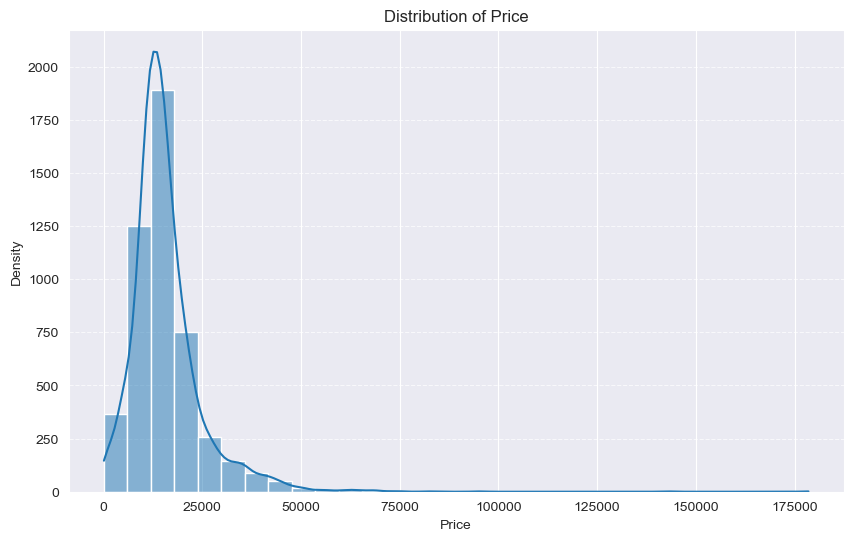

In [7]:
# Plot the probabilistic distribution of the target variable 'price'
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True, bins=30)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### 2.3. Distribution of numerical variables
Plot the probabilistic distribution of the numerical features.


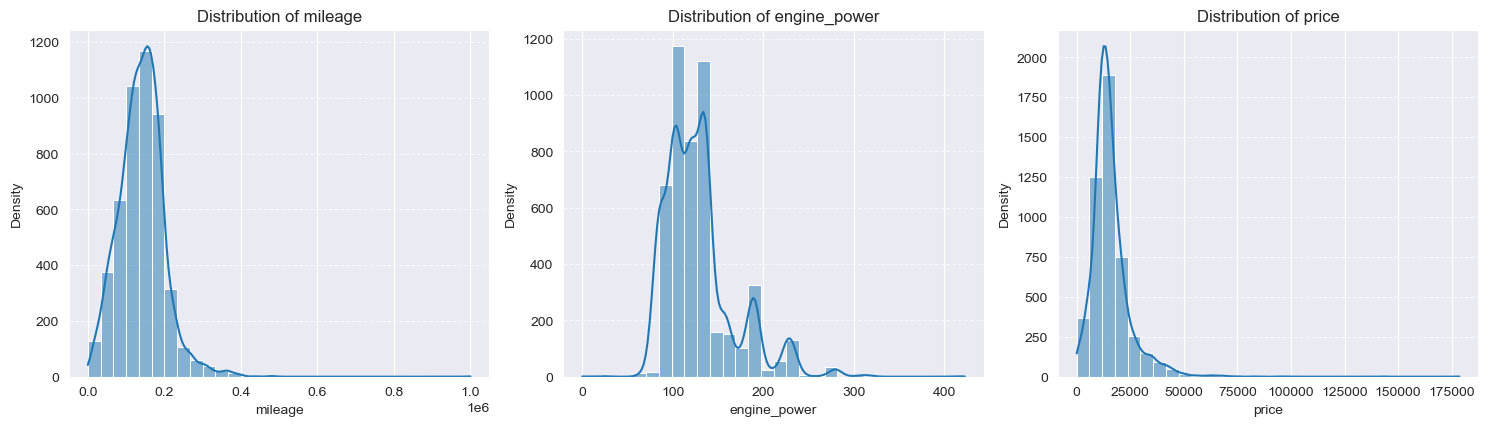

In [8]:
numerical_features = df.select_dtypes(include=['int64']).columns

# Plot the probabilistic distribution of the numerical features
plt.figure(figsize=(15, 12))
for idx, feature in enumerate(numerical_features):
    plt.subplot(3, 3, idx + 1)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### 2.4. Histogram of categorical variables
Plot the histogram of the categorical features.

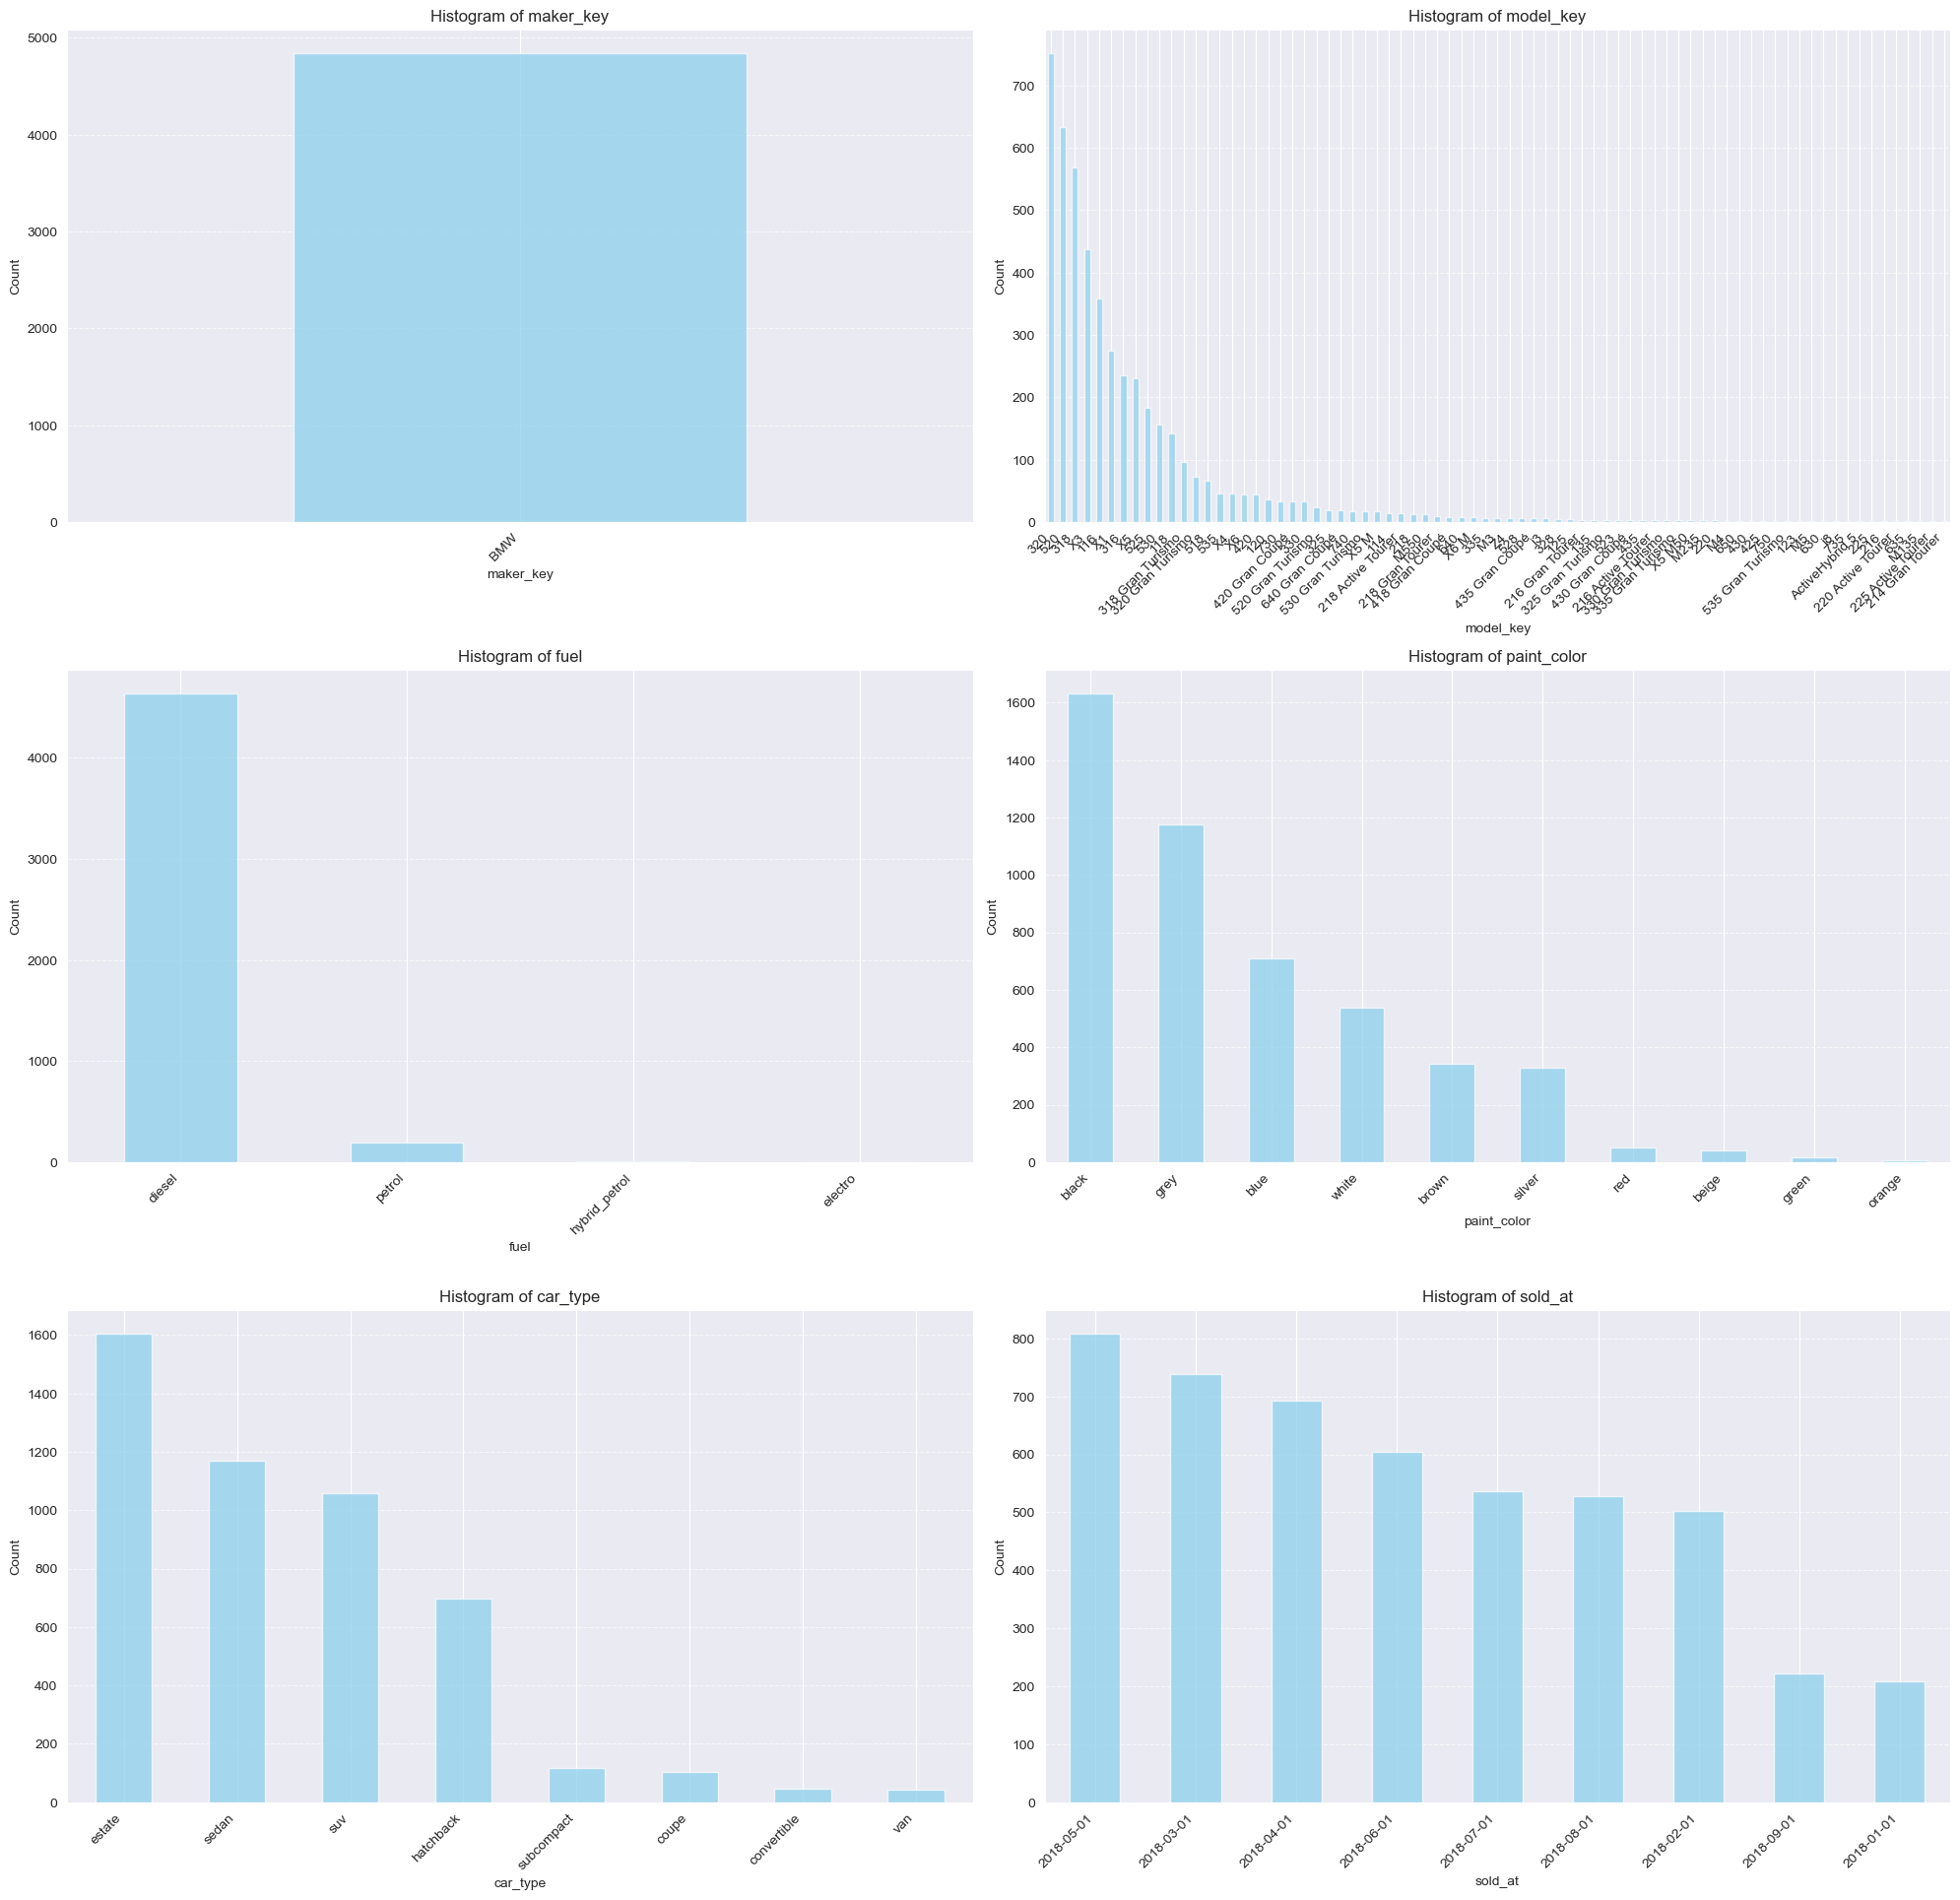

In [9]:
# Selecting only categorical features from the dataset
categorical_features = df.select_dtypes(include=['object']).columns
# Adjusting the histogram plots for categorical features for better readability

# Filtering out 'registration_date' as it doesn't suit categorical plotting in this form
filtered_categorical_features = categorical_features.drop('registration_date')

# Plot the histogram of the categorical features with better visualization
plt.figure(figsize=(20, 25))
for idx, feature in enumerate(filtered_categorical_features):
    plt.subplot(4, 2, idx + 1)
    df[feature].value_counts().plot(kind='bar', color='skyblue', alpha=0.7)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## 3. Data Splitting

Split the dataset into 2 training and test datasets.

In [10]:
def split_data(df, ratio=0.8):
    # we just need to shuffle the data before proceeding, and reset the index
    shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # we're getting the ratio
    index = int(df.shape[0] * ratio)

    # so here we're splitting the data into test and train using our index variable
    train_df = shuffled_df.iloc[:index]
    test_df = shuffled_df.iloc[index:]

    # and we're getting the data used to predict and dropping it from X_train and X_test
    y_train = train_df['price']
    y_test = test_df['price']
    X_train = train_df.drop(columns=['price', 'price^2'], axis=1)
    X_test = test_df.drop(columns=['price', 'price^2'], axis=1)

    return X_train, y_train, X_test, y_test

In [11]:
# Just printing the head of the dataframe before shuffling
df.head()

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,BMW,118,140411,100,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2018-01-01
1,BMW,M4,13929,317,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2018-02-01
2,BMW,320,183297,120,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2018-02-01
3,BMW,420,128035,135,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2018-02-01
4,BMW,425,97097,160,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,2018-04-01


    ## 4. Feature Engineering

### 4.1. Removing non-predictive features

Remove any unnecessary feature.

We can categorize unnecessary features as an id, a string that's not really necessary, in our case the maker since they're all the same

In [12]:
df.reset_index(drop=True, inplace=True)
df.drop('maker_key', axis=1, inplace=True)
df.drop('model_key', axis=1, inplace=True)
df.drop('registration_date', axis=1, inplace=True)
df.drop('sold_at', axis=1, inplace=True)

### 4.2. Creating new features

Creating polynomial features for numerical columns


In [1]:
numerical_columns = df.select_dtypes(include=['int64']).columns

degree = 2

# Create polynomial features up to the specified degree
for col in numerical_columns:
    for d in range(2, degree + 1):
        new_col_name = f"{col}^" + str(d)
        df[new_col_name] = df[col] ** d


NameError: name 'df' is not defined

In [14]:
df.head()

,mileage,engine_power,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,mileage^2,engine_power^2,price^2
0,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,19715248921,10000,127690000
1,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,194017041,100489,4858090000
2,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,33597790209,14400,104040000
3,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,16392961225,18225,630010000
4,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,9427827409,25600,1115560000


### 4.3. Scaling numerical variables

In [15]:
# Select numerical columns as we added some
numerical_columns = df.select_dtypes(include=['int64']).columns

# Calculate mean and standard deviation for scaling
for col in numerical_columns:
    mean = df[col].mean()
    std = df[col].std()
    df[col] = (df[col] - mean) / std

In [16]:
df.head()

,mileage,engine_power,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,mileage^2,engine_power^2,price^2
0,-0.009167,-0.743415,diesel,black,convertible,True,True,False,False,True,True,True,False,-0.491100,-0.156280,-0.645707,-0.293588
1,-2.110310,4.821636,petrol,grey,convertible,True,True,False,False,False,True,True,True,5.842760,-0.963755,6.516391,6.388601
2,0.703264,-0.230507,diesel,white,convertible,False,False,False,False,True,False,True,False,-0.610402,0.417957,-0.297452,-0.326996
3,-0.214759,0.154174,diesel,red,convertible,True,True,False,False,True,True,True,True,1.005600,-0.293703,0.005293,0.415992
4,-0.728707,0.795309,diesel,silver,convertible,True,True,False,False,False,True,True,True,1.905789,-0.581808,0.589015,1.101883


### 4.4. Categorical variables encoding

Convert categorical columns into numerical columns using label encoding or one-hot encoding.


In [17]:
categorical_columns = df.select_dtypes(include=['object', 'datetime']).columns

for col in categorical_columns:
    unique_values = df[col].unique()
    encoding_map = {value: label for label, value in enumerate(unique_values)}
    df[col] = df[col].map(encoding_map)

### 4.5. Converting boolean columns

Convert categorical columns into numerical columns using label encoding or one-hot encoding.


In [18]:
boolean_columns = df.select_dtypes(include=['bool']).columns

for col in boolean_columns:
    df[col] = df[col].apply(lambda x: 1 if x == True else 0)

### 4.6 Splitting the data

we're going to use the previously created split_data function

In [19]:
X_train, y_train, X_test, y_test = split_data(df, ratio=0.8)

## 5. Linear Regression

### 5.1 Fit a linear regression model on the training set. Evaluate the model on the testing set. Use the $R^2$ as an evaluation metric.


In [20]:
linearRegression = LinearRegression()

# fit the model to the training data
linearRegression.fit(X_train, y_train)

# use the model to predict on the test set
y_pred_Linear_regression = linearRegression.predict(X_test)

# Here I'm simply getting the R2 score of this model
linearRegression_R2 = r2_score(y_test, y_pred_Linear_regression)

# evaluate the model using r2_score
print("R squared score of the LinearRegression model: ", linearRegression_R2)

# Here I'm simply getting the MSE score of this model
linearRegression_MSE = mean_squared_error(y_test, y_pred_Linear_regression)

# Evaluate the model using MSE score
print("MSE of lasso model: ", linearRegression_MSE)

R squared score of the LinearRegression model:  0.7118096486631907
MSE of lasso model:  0.2858153086492029


### 5.2 Plot feature importance/weight.

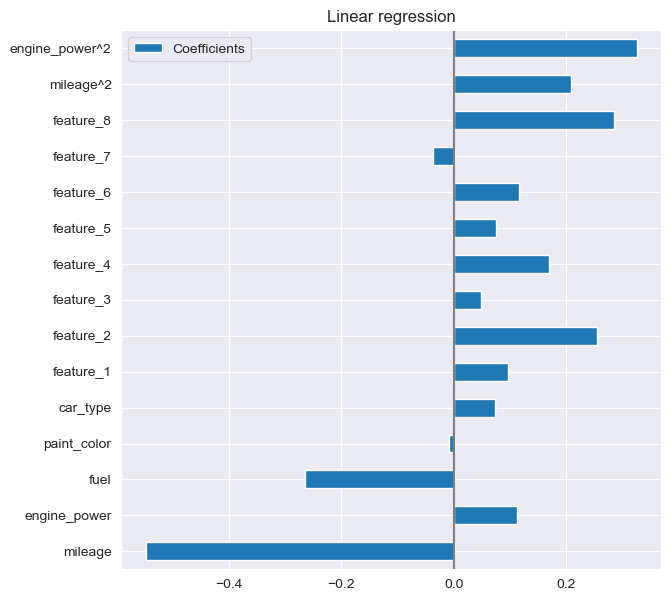

In [21]:
linearRegression_coefs = pd.DataFrame(
    linearRegression.coef_, columns=["Coefficients"], index=X_train.columns
)
linearRegression_coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Linear regression")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

## 6. Ridge
### 6.1 Fit a ridge regression model on the training set. Use cross-validation in order to tune the regularization parameter of the ridge model. Evaluate the model on the testing set. Use the $R^2$ as an evaluation metric.


In [22]:
# define a list of alpha
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

# create and fit the RidgeCV regression model
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

# Getting the best alpha found by the LassoCv model
best_alpha_ridge = ridge_cv.alpha_

# Print the best alpha value that we got from fitting ridge_cv
print(f"Best alpha value found by RidgeCV: {best_alpha_ridge}")

# use the model to predict on the test set
y_pred_ridge = ridge_cv.predict(X_test)

# Here I'm simply getting the R2 score of this model
ridgeCV_R2 = r2_score(y_test, y_pred_ridge)

# evaluate the model using r2_score
print("R squared score of ridge model: ", ridgeCV_R2)

# Here I'm simply getting the MSE score of this model
ridgeCV_MSE = mean_squared_error(y_test, y_pred_ridge)

# Evaluate the model using MSE score
print("MSE of lasso model: ", ridgeCV_MSE)

Best alpha value found by RidgeCV: 100.0
R squared score of ridge model:  0.7081001806275931
MSE of lasso model:  0.28949420610916543


### 6.2 Plot feature importance/weight.

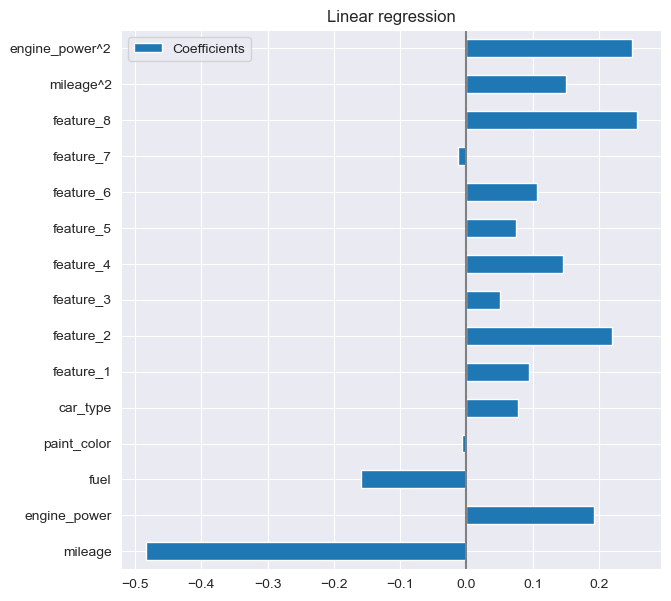

In [23]:
ridge_coefs = pd.DataFrame(
    ridge_cv.coef_, columns=["Coefficients"], index=X_train.columns
)
ridge_coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Linear regression")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

## 7. Lasso
### 7.1 Fit a lasso regression model on the training set. Use cross-validation in order to tune the regularization parameter of the ridge model. Evaluate the model on the testing set. Use the $R^2$ as an evaluation metric.


In [24]:
# define a list of alpha
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

# create and fit the LassoCV regression model
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

# Getting the best alpha found by the LassoCv model
best_alpha_lasso = lasso_cv.alpha_

# Print the best alpha value that we got from fitting lasso_cv
print(f"Best alpha value found by LassoCV: {best_alpha_lasso}")

# use the model to predict on the test set
y_pred_lasso = lasso_cv.predict(X_test)

# Here I'm simply getting the R2 score of this model
lassoCV_R2 = r2_score(y_test, y_pred_lasso)

# evaluate the model using r2 score
print("R squared score of lasso model: ", lassoCV_R2)

# Here I'm simply getting the MSE score of this model
lassoCV_MSE = mean_squared_error(y_test, y_pred_lasso)

# Evaluate the model using MSE score
print("MSE of lasso model: ", lassoCV_MSE)

Best alpha value found by LassoCV: 0.001
R squared score of lasso model:  0.7116424308861267
MSE of lasso model:  0.28598114834626953


### 7.2 Plot feature importance/weight.

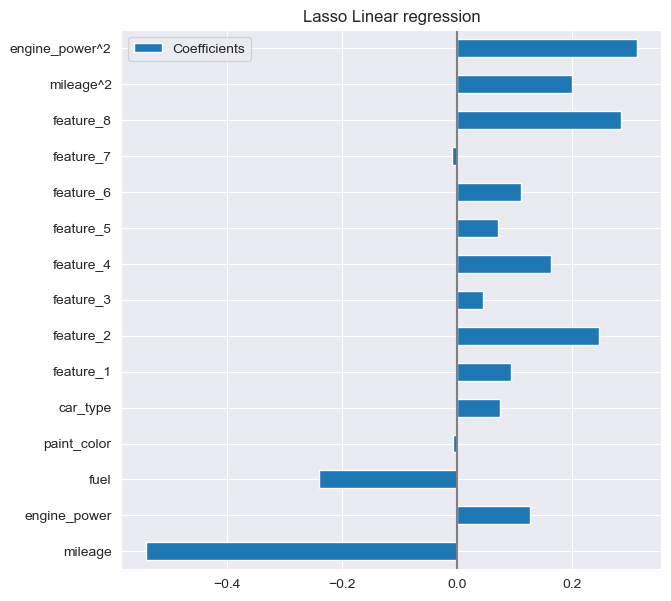

In [25]:
lasso_coefs = pd.DataFrame(
    lasso_cv.coef_, columns=["Coefficients"], index=X_train.columns
)
lasso_coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Lasso Linear regression")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)
plt.show()

## 8. Model comparison

   ### 8.1 $R^2$ comparison

The goal here is to compare the $R^2$ metric to see which of the model has performed the best, and in the case of RidgeCV and LassoCV, compare which alpha value the cross validation chose to get the best out of the parameters

In [26]:
R2_scores = {'LinearRegression': linearRegression_R2,
             'RidgeCV': ridgeCV_R2,
             'LassoCV': lassoCV_R2}

print("R squared score of the LinearRegression model: ", R2_scores['LinearRegression'])

ridge_R2 = r2_score(y_test, y_pred_ridge)
print("R squared score of RidgeCV model: ", R2_scores['RidgeCV'])

lasso_R2 = r2_score(y_test, y_pred_lasso)
print("R squared score of LassoCV model: ", R2_scores['LassoCV'])

R squared score of the LinearRegression model:  0.7118096486631907
R squared score of RidgeCV model:  0.7081001806275931
R squared score of LassoCV model:  0.7116424308861267


We're plotting $R^2$ scores of the different models so that we can compare the small yet significant variations between the models

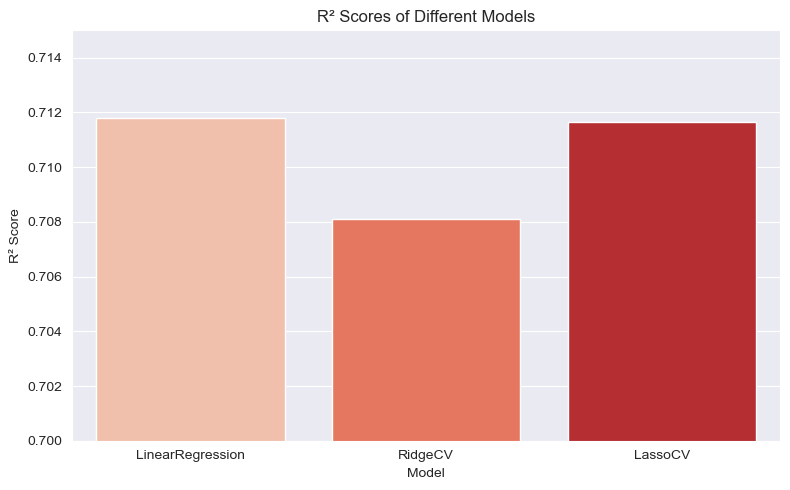

In [27]:
plt.figure(figsize=(8, 5))
sns.barplot(x=list(R2_scores.keys()), y=list(R2_scores.values()), palette='Reds')
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.ylim(0.70, 0.715)
plt.title('R² Scores of Different Models')
plt.tight_layout()
plt.show()

In conclusion, we evaluated multiple linear regression models, including Linear Regression, Ridge Regression, and Lasso Regression. By using cross-validation and hyperparameter tuning, we were able to identify the optimal model parameters and compare their performance based on R² scores. All three models performed similarly, but slight variations in the R² scores highlight the benefits of regularization. Ridge and Lasso helped reduce overfitting while maintaining comparable predictive power. Feature importance analysis further provided insights into which features were most impactful in predicting car prices, helping us better understand the relationships in the data.

### 8.2 MSE comparison
Here by stocking the alphas in a dictionary we're going to be able to compare them and see the difference

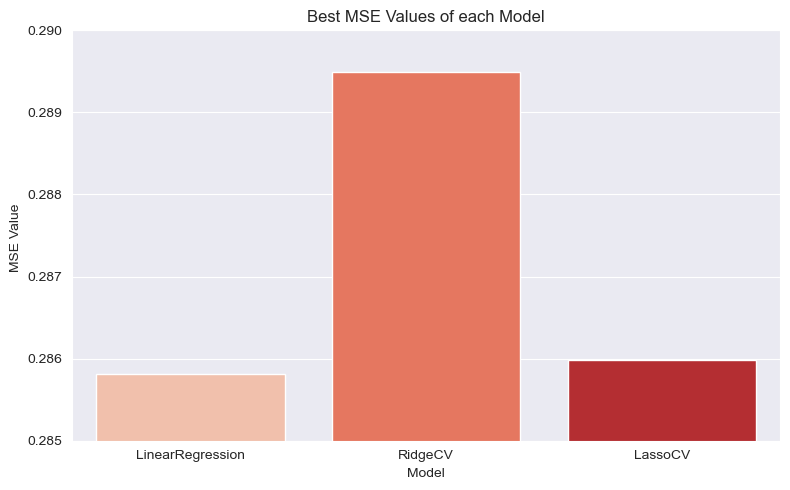

In [28]:
model_MSE = {'LinearRegression': linearRegression_MSE,
          'RidgeCV': ridgeCV_MSE,
          'LassoCV': lassoCV_MSE}
plt.figure(figsize=(8, 5))
sns.barplot(x=list(model_MSE.keys()), y=list(model_MSE.values()), palette='Reds')
plt.xlabel('Model')
plt.ylabel('MSE Value ')
plt.ylim(0.285, 0.29)
plt.title('Best MSE Values of each Model')
plt.tight_layout()
plt.show()

Here the $MSE$ of the RidgeCV model is a just a bit yet significantly higher than LassoCV's and LinearRegression's $MSE$. Compared to the $R^2$, RidgeCV was lower than the two others, this can be explained by RidgeCV applying stronger regularization, thereby reducing model complexity at the cost of slightly lower predictive accuracy.

### 8.3 Alpha's comparison

Here by stocking the alphas in a dictionary we're going to be able to compare them and see the difference

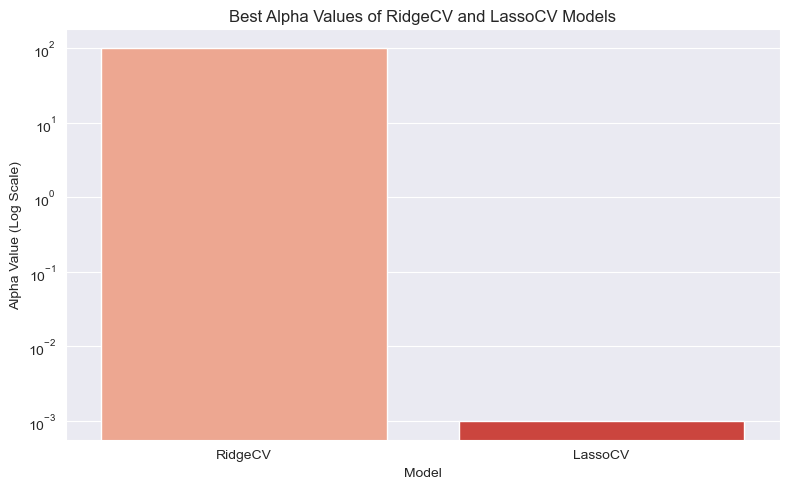

In [29]:
model_alphas = {'RidgeCV': best_alpha_ridge,
                'LassoCV': best_alpha_lasso}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(model_alphas.keys()), y=list(model_alphas.values()), palette='Reds')
plt.yscale('log')
plt.xlabel('Model')
plt.ylabel('Alpha Value (Log Scale)')
plt.title('Best Alpha Values of RidgeCV and LassoCV Models')
plt.tight_layout()
plt.show()

### 8.4 Features comparison
After comparing alphas and $R^2$ scores we can understand for each model which features has been important or not. First let's remind us what are the three plots we found for each model

<Figure size 800x800 with 0 Axes>

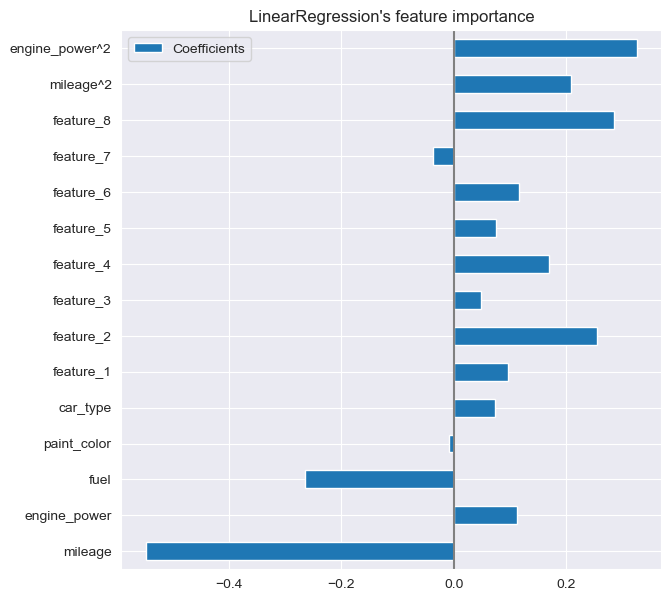

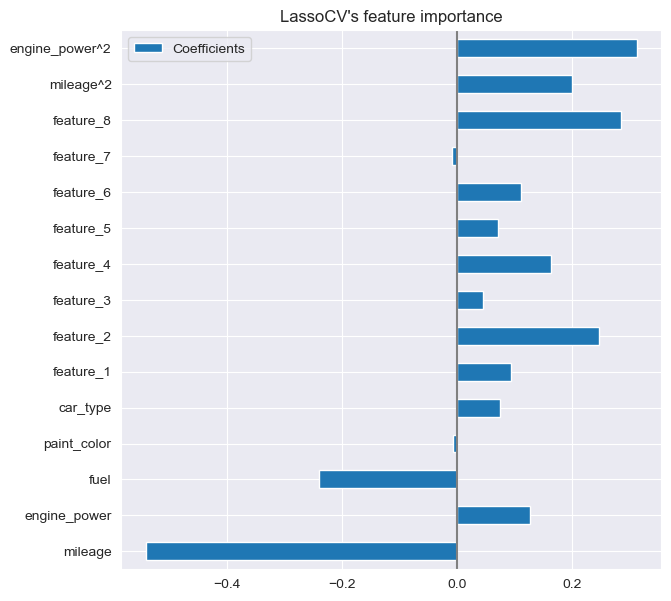

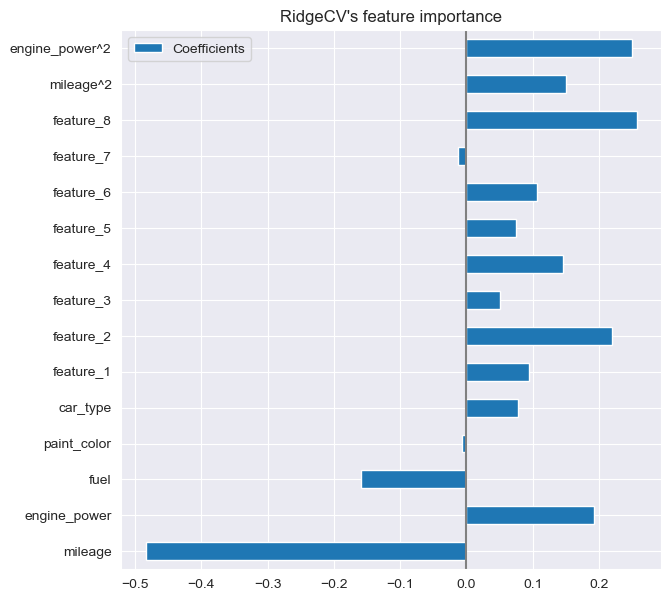

<Figure size 640x480 with 0 Axes>

In [30]:
model_coefs = {'LinearRegression': linearRegression_coefs,
               'LassoCV': lasso_coefs,
               'RidgeCV': ridge_coefs}
plt.figure(figsize=(8, 8))
for name, coefs in model_coefs.items():
    coefs.plot(kind="barh", figsize=(9, 7))
    plt.title("{name}'s feature importance".format(name=name))
    plt.axvline(x=0, color=".5")
    plt.subplots_adjust(left=0.3)
    plt.show()
plt.tight_layout()
plt.show()


It's clear that the mileage has a lot to do with the car's price, but when we're comparing the models we can see that some feature's importance may vary from one model to another. In RidgeCV's model the car's engine power is way more important than in the two other ones, and even when comparing LassoCV and LinearRegression this feature's importance respectively lowers. and this can be explained by the different levels of regularization. RidgeCV applies stronger L2 regularization, which reduces the influence of less important features but may also limit the impact of more critical ones like engine power, resulting in a shift in feature importance compared to LassoCV and LinearRegression.

## 9. Conclusion

This project successfully predicted the auction price of used BMW cars using various features like vehicle attributes and equipment criteria. Through exploratory data analysis, significant patterns and influential features were identified. The modeling phase utilized linear, Ridge, and Lasso regressions, with Ridge providing the best results. These findings provide a valuable basis for pricing strategies in the used car market, highlighting data-driven insights for better decision-making.